# Gesture Recognition

In [ ]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize - deprecated
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In [ ]:
!nvidia-smi

Tue Jan 25 17:36:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

!unzip drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/Project_data.zip
os.chdir('/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project')  #change dir
!unzip -q Project_data.zip -d data/  #unzip data 

### Defining train and test paths:

In [8]:
tr_l = os.listdir('/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train') # dir is your directory path
number_files_tr = len(tr_l)
v_l = os.listdir('/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/val') # dir is your directory path
number_files_l = len(v_l)
print('No. of video files in train data: '+str(number_files_tr))
print('No. of video files in validation data: '+str(number_files_l))

No. of video files in train data: 663
No. of video files in validation data: 100


In [9]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/val.csv').readlines())
batch_size = 64 

## Generator
In the generator, we preprocess the images as the images are of 2 different dimensions as well as create a batch of video frames.

Images have two sizes: 360x360 and 120x120. All images are therefore resized to 128x128.  

In [10]:
import cv2

In [11]:
def generator(source_path, folder_list, batch_size,idx_n,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size) #batch_size: Creating empty containers (zero tensors) to input values of images
    img_idx = [i for i in range(0,29,idx_n)] #creating list of image numbers for a particular video as not all 30 images are needed, to reduce training time
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size  # number of videos//batch_size (remaining videos dealt with separately)
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #cropping and resizing images as images were of 2 different sizes and the conv3D will throw error if the inputs in a batch have different shapes
                    crop_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    crop_image = crop_image[0:y, 20:20+y]
                    res_img = resize(crop_image,(y,z,3))
                    #normalise and feed in the cropped image
                    batch_data[folder,idx,:,:,0] = (res_img[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (res_img[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (res_img[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        rem_batches = len(t)%batch_size
        if rem_batches!=0: 
          for folder in range(rem_batches): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*rem_batches)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
              image = imread(source_path+'/'+ t[folder + (batch*rem_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

              crop_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              crop_image = crop_image[0:y, 20:20+y]
              res_img = resize(crop_image,(y,z,3))

              batch_data[folder,idx,:,:,0] = (res_img[:,:,0])/255
              batch_data[folder,idx,:,:,1] = (res_img[:,:,1])/255
              batch_data[folder,idx,:,:,2] = (res_img[:,:,2])/255
                    
            batch_labels[folder, int(t[folder + (batch*rem_batches)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels 

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train'
val_path = '/content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size, 2, 128, 128)
val_generator = generator(val_path, val_doc, batch_size, 2, 128, 128)

### Checking an image from the dataset:

In [15]:
sample_val_batch_data, sample_val_batch_labels = next(val_generator)

Source path =  /content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/val ; batch size = 64


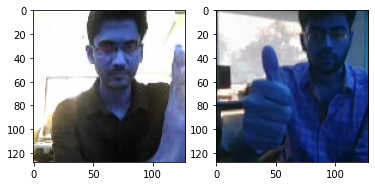

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
#from keras.applications.vgg16 import VGG16

**Model 1 - Conv3D_1 - Training Conv3D Model on batch size = 64, no of frames = 15 and img size = 128x128.**

In [ ]:
optimiser = 'adam' 

In [ ]:
model1 = Sequential()
model1.add(Conv3D(filters = 16, kernel_size = (3,3,3), padding='same',
                 activation ='relu', input_shape = (15,128,128,3)))  
model1.add(Conv3D(filters = 16, kernel_size = (3,3,3), padding='same',
                 activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Conv3D(filters = 16, kernel_size = (3,3,3), padding='same',
                 activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Conv3D(filters = 32, kernel_size = (3,3,3), padding='same',
                 activation ='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))
model1.add(Conv3D(filters = 32, kernel_size = (3,3,3), padding='same',
                 activation ='relu'))
model1.add(Dropout(0.5))


model1.add(Flatten())
model1.add(Dense(64, activation='relu')) # fully connected

#Softmax layer
model1.add(Dense(5, activation = "softmax"))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 128, 128, 16)  1312      
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 128, 128, 16)  6928      
                                                                 
 batch_normalization (BatchN  (None, 15, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 64, 64, 16)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 7, 64, 64, 16)     6928      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 64, 64, 16)   

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Ablation Experiment:

In [ ]:
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, verbose=1,
 validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train ; batch size = 64
11/11 [==============================] - 2138s 212s/step - loss: 1.9380 - categorical_accuracy: 0.2614 - val_loss: 1.6098 - val_categorical_accuracy: 0.1719


### Callback:

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.001, patience=4, min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#### Model Training:

In [ ]:
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
 validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - 219s 22s/step - loss: 1.3740 - categorical_accuracy: 0.3949 - val_loss: 1.7834 - val_categorical_accuracy: 0.1953
Epoch 2/20
11/11 [==============================] - 143s 14s/step - loss: 1.2271 - categorical_accuracy: 0.5014 - val_loss: 1.7830 - val_categorical_accuracy: 0.2188
Epoch 3/20
11/11 [==============================] - 130s 13s/step - loss: 1.0835 - categorical_accuracy: 0.5597 - val_loss: 1.8526 - val_categorical_accuracy: 0.2344
Epoch 4/20
11/11 [==============================] - 139s 14s/step - loss: 0.9813 - categorical_accuracy: 0.6520 - val_loss: 1.6759 - val_categorical_accuracy: 0.2188
Epoch 5/20
11/11 [==============================] - 136s 13s/step - loss: 0.8443 - categorical_accuracy: 0.6932 - val_loss: 1.6113 - val_categorical_accuracy: 0.2969
Epoch 6/20
11/11 [==============================] - 136s 13s/step - loss: 0.7449 - categorical_accuracy: 0.7429 - val_loss: 1.5209 - val_categorical_accuracy: 0.2969
Epoc

Model 2 - Conv3D_2 
**Model 2 - Conv3D_2 - Training Conv3D Model on batch size = 64, no of frames = 30 and img size = 128x128.**

train_generator = generator(train_path, train_doc, batch_size, 1, 128, 128)
val_generator = generator(val_path, val_doc, batch_size, 1, 128, 128)

model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model 3 - Conv3D_3 
**Model 3 - Conv3D_3 - Training Conv3D Model on batch size = 64, no of frames = 15 and img size = 200x200.**

train_generator = generator(train_path, train_doc, batch_size, 2, 200, 200)
val_generator = generator(val_path, val_doc, batch_size, 2, 200, 200)

model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


### Model 4 - Conv2D + LSTM
- Refer: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [ ]:
model4 = Sequential()
model4.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape = (15, 128, 128, 3)))
model4.add(TimeDistributed(MaxPooling2D((2,2))))

model4.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))

model4.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))

model4.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2,2))))

model4.add(TimeDistributed(Flatten()))

model4.add(LSTM(128, activation='relu', return_sequences=False))
model4.add(Dropout(0.25))

model4.add(Dense(5, activation='softmax'))
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 32, 32, 64)  

In [ ]:
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
11/11 [==============================] - 122s 11s/step - loss: 11.2364 - categorical_accuracy: 0.2228 - val_loss: 1.5780 - val_categorical_accuracy: 0.2451
Epoch 2/20
11/11 [==============================] - 115s 11s/step - loss: 3.5045 - categorical_accuracy: 0.2674 - val_loss: 1.5809 - val_categorical_accuracy: 0.3137
Epoch 3/20
11/11 [==============================] - 127s 13s/step - loss: 2.3520 - categorical_accuracy: 0.2923 - val_loss: 1.6771 - val_categorical_accuracy: 0.2549
Epoch 4/20
11/11 [==============================] - 127s 13s/step - loss: 1.8190 - categorical_accuracy: 0.2781 - val_loss: 1.6279 - val_categorical_accuracy: 0.2353
Epoch 5/20
11/11 [==============================] - 117s 12s/step - loss: 1.9780 - categorical_accuracy: 0.3280 - val_loss: 1.5921 - val_categorical_accuracy: 0.2647
Epoch 6/20
11/11 [==============================] - 126s 13s/step - loss: 1.4619 - categorical_accuracy: 0.4135 - val_loss: 1.5665 - val_categorical_accuracy: 0.2745
Epo

Model 5 - Conv 2D + GRU

In [ ]:
model5 = Sequential()
model5.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape = (15, 128, 128, 3)))
model5.add(TimeDistributed(MaxPooling2D((2,2))))

model5.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))

model5.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))

model5.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))

model5.add(TimeDistributed(Flatten()))

model5.add(GRU(128, activation='relu', return_sequences=False))
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 32, 32, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 32, 32, 64)  

In [ ]:
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - 2325s 230s/step - loss: 1.6653 - categorical_accuracy: 0.1861 - val_loss: 1.5990 - val_categorical_accuracy: 0.2031
Epoch 2/20
11/11 [==============================] - 354s 33s/step - loss: 1.6237 - categorical_accuracy: 0.2145 - val_loss: 1.5516 - val_categorical_accuracy: 0.2656
Epoch 3/20
11/11 [==============================] - 314s 29s/step - loss: 1.5274 - categorical_accuracy: 0.3295 - val_loss: 1.4072 - val_categorical_accuracy: 0.4375
Epoch 4/20
11/11 [==============================] - 306s 28s/step - loss: 1.3857 - categorical_accuracy: 0.4574 - val_loss: 1.2068 - val_categorical_accuracy: 0.5391
Epoch 5/20
11/11 [==============================] - 309s 28s/step - loss: 1.2623 - categorical_accuracy: 0.5241 - val_loss: 1.1346 - val_categorical_accuracy: 0.5781
Epoch 6/20
11/11 [==========================

In [ ]:
model6 = Sequential()
model6.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),input_shape = (15, 128, 128, 3)))
model6.add(TimeDistributed(MaxPooling2D((2,2))))

model6.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))

model6.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))

model6.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))

model6.add(TimeDistributed(Flatten()))

model6.add(GRU(128, activation='relu', return_sequences=False))
model6.add(Dropout(0.5))

model6.add(Dense(5, activation='softmax'))
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 128, 128, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 64, 64, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 32, 32, 32)  

In [ ]:
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
11/11 [==============================] - 357s 32s/step - loss: 3.0402 - categorical_accuracy: 0.3224 - val_loss: 1.5996 - val_categorical_accuracy: 0.2344
Epoch 2/20
11/11 [==============================] - 340s 31s/step - loss: 1.5021 - categorical_accuracy: 0.4332 - val_loss: 1.6985 - val_categorical_accuracy: 0.2344
Epoch 3/20
11/11 [==============================] - 338s 31s/step - loss: 1.3316 - categorical_accuracy: 0.4588 - val_loss: 2.4342 - val_categorical_accuracy: 0.2188
Epoch 4/20
11/11 [==============================] - 346s 32s/step - loss: 1.2038 - categorical_accuracy: 0.5057 - val_loss: 2.7537 - val_categorical_accuracy: 0.1484
Epoch 5/20
11/11 [==============================] - 340s 31s/step - loss: 1.1216 - categorical_accuracy: 0.5469 - val_loss: 3.4684 - val_categorical_accuracy: 0.2344
Epoch 6/20
11/11 [==============================] - 340s 31s/step - loss: 1.0678 - categorical_accuracy: 0.5866 - val_loss: 3.5996 - val_categorical_accuracy: 0.2500
Epoc

Model 7 - TL VGG16 + RNN

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, 2, 224, 224)
val_generator = generator(val_path, val_doc, batch_size, 2, 224, 224)

In [ ]:
model7 = Sequential([
    TimeDistributed(VGG16(), input_shape=(15,224,224,3))])

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
#model7.add(TimeDistributed(MaxPooling2D((2,2))))

model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(128))
model7.add(Dropout(0.25))

model7.add(Dense(128,activation='relu'))
model7.add(Dropout(0.25))

model7.add(Dense(5, activation='softmax'))

In [ ]:
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/IIIT-B_CollabNB/Gesture Recognition Project/data/Project_data/train ; batch size = 64
Epoch 1/20
